Starting episode 1
No vehicles left, terminating simulation.
Episode 1 finished with total reward: 445452.31
Starting episode 2
No vehicles left, terminating simulation.
Episode 2 finished with total reward: 447116.41
Starting episode 3
No vehicles left, terminating simulation.
Episode 3 finished with total reward: 446545.56
Starting episode 4
No vehicles left, terminating simulation.
Episode 4 finished with total reward: 445261.23
Starting episode 5
No vehicles left, terminating simulation.
Episode 5 finished with total reward: 445563.51
Starting episode 6
No vehicles left, terminating simulation.
Episode 6 finished with total reward: 446511.15
Starting episode 7
No vehicles left, terminating simulation.
Episode 7 finished with total reward: 446287.34
Starting episode 8
No vehicles left, terminating simulation.
Episode 8 finished with total reward: 446626.37
Starting episode 9
No vehicles left, terminating simulation.
Episode 9 finished with total reward: 446062.29
Starting episode 10

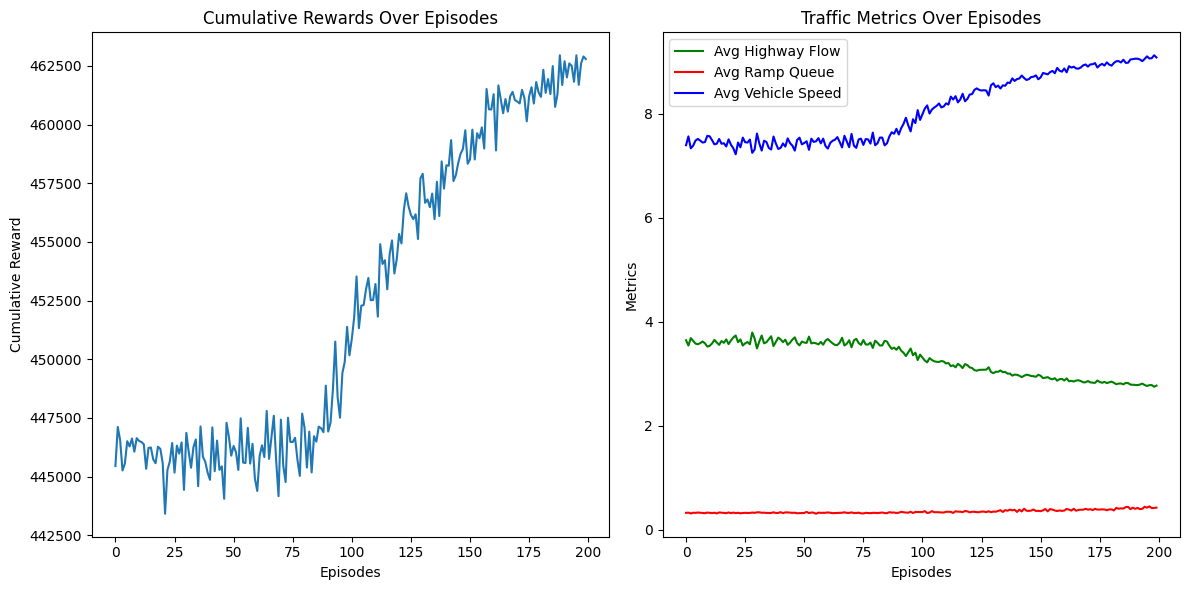

: 

In [1]:
import traci
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

# Hyperparameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.95  # Discount factor
EPSILON = 1.5  # Initial exploration rate
EPSILON_DECAY = 0.005  # Slow down decay to allow more exploration initially
MIN_EPSILON = 0.1  # A higher minimum epsilon allows more exploration later
NUM_EPISODES = 200
CONVERGENCE_THRESHOLD = 1e-3
REPLAY_BUFFER_SIZE = 1000
BATCH_SIZE = 32

# Initialize Q-table
num_states_traffic = 11
num_states_queue = 11
num_actions = 3
q_table = np.zeros((num_states_traffic, num_states_queue, num_actions))

# Replay buffer for experience replay
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

# Helper functions
def reset_simulation():
    """Reset the SUMO simulation to the starting point."""
    traci.load(["--net-file", "test1.net.xml", "--route-files", "test1.rou.xml", "--additional-files", "test1.add.xml"])
    return get_state()

def get_state():
    """Retrieve the current state of the system."""
    highway_traffic = min(traci.edge.getLastStepVehicleNumber("E0") / 10, 1)  # Normalize to [0, 1]
    ramp_queue = min(traci.edge.getLastStepVehicleNumber("E2") / 10, 1)  # Normalize to [0, 1]
    traffic_light_phase = traci.trafficlight.getPhase("J1")
    return (highway_traffic, ramp_queue, traffic_light_phase)

def calculate_reward(highway_flow, ramp_queue, vehicle_speed):
    """Calculate reward based on system performance."""
    highway_flow_weight = 7 
    ramp_queue_weight = -2.1 
    vehicle_speed_weight = 5
    reward = (highway_flow * highway_flow_weight) + \
             (ramp_queue * ramp_queue_weight) + \
             (vehicle_speed * vehicle_speed_weight)
    return reward

def select_action(state, epsilon):
    """Select an action based on the epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2])  # Explore: random action
    else:
        state_indices = (int(state[0] * 10), int(state[1] * 10), state[2])
        return np.argmax(q_table[state_indices])  # Exploit: best known action

def update_q_values(state, action, reward, next_state, done, alpha=0.1, gamma=0.95):
    """Update the Q-values using the Q-learning formula."""
    state_indices = (int(state[0] * 10), int(state[1] * 10), state[2])
    next_state_indices = (int(next_state[0] * 10), int(next_state[1] * 10), next_state[2])
    current_q = q_table[state_indices]
    max_next_q = np.max(q_table[next_state_indices])
    new_q = current_q + alpha * (reward + gamma * max_next_q - current_q)
    q_table[state_indices] = new_q

def take_action(action):
    """Take the action in the simulation and return the new state, reward, and done flag."""
    traci.trafficlight.setPhase("J1", action)
    if traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
    else:
        print("No vehicles left, terminating simulation.")
        return None, 0, True

    next_state = get_state()
    highway_flow = traci.edge.getLastStepVehicleNumber("E0")
    ramp_queue = traci.edge.getLastStepVehicleNumber("E2")
    avg_speed = traci.edge.getLastStepMeanSpeed("E0")
    reward = calculate_reward(highway_flow, ramp_queue, avg_speed)
    done = False
    return next_state, reward, done

def replay_experience():
    """Perform experience replay to stabilize learning."""
    if len(replay_buffer) < BATCH_SIZE:
        return
    batch = random.sample(replay_buffer, BATCH_SIZE)
    for state, action, reward, next_state in batch:
        update_q_values(state, action, reward, next_state, False)

# Run simulation
sumo_binary = "sumo"
sumo_config_file = "test1.sumocfg"
traci.start([sumo_binary, "-c", sumo_config_file])

# Metrics for monitoring performance
cumulative_rewards = []
avg_highway_flows = []
avg_ramp_queues = []
vehicle_speeds = []

# Training loop
for episode in range(NUM_EPISODES):
    print(f"Starting episode {episode + 1}")
    total_reward = 0
    state = reset_simulation()
    done = False

    q_table_prev = q_table.copy()
    episode_highway_flows = []
    episode_ramp_queues = []
    episode_speeds = []

    while not done:
        if state is None:
            break
        action = select_action(state, EPSILON)
        next_state, reward, done = take_action(action)
        total_reward += reward

        if next_state is not None:
            replay_buffer.append((state, action, reward, next_state))
            update_q_values(state, action, reward, next_state, done)
            state = next_state

        highway_flow = traci.edge.getLastStepVehicleNumber("E0")
        ramp_queue = traci.edge.getLastStepVehicleNumber("E2")
        avg_speed = traci.edge.getLastStepMeanSpeed("E0")
        episode_highway_flows.append(highway_flow)
        episode_ramp_queues.append(ramp_queue)
        episode_speeds.append(avg_speed)

        replay_experience()

    cumulative_rewards.append(total_reward)
    avg_highway_flows.append(np.mean(episode_highway_flows))
    avg_ramp_queues.append(np.mean(episode_ramp_queues))
    vehicle_speeds.append(np.mean(episode_speeds))

    print(f"Episode {episode + 1} finished with total reward: {total_reward:.2f}")
    EPSILON = max(MIN_EPSILON, EPSILON * (1 - EPSILON_DECAY))

    max_change = np.max(np.abs(q_table - q_table_prev))
    if max_change < CONVERGENCE_THRESHOLD:
        print(f"Convergence reached at episode {episode + 1} (Q-table change: {max_change:.6f})")
        break

traci.close()

# Plotting results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")

plt.subplot(1, 2, 2)
plt.plot(avg_highway_flows, label="Avg Highway Flow", color="green")
plt.plot(avg_ramp_queues, label="Avg Ramp Queue", color="red")
plt.plot(vehicle_speeds, label="Avg Vehicle Speed", color="blue")
plt.title("Traffic Metrics Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Metrics")
plt.legend()

plt.tight_layout()
plt.show()
